In [51]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
from tensorflow.keras.applications import InceptionV3


In [52]:

pre_trained_model = InceptionV3(include_top=False,
                 weights= None,
                 input_shape=(224,224,3),
                 pooling='avg',
                 )

# for layer in pre_trained_model.layers:
#     layer.trainable=False
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 111, 111, 32) 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 111, 111, 32) 0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

In [53]:
last_layer=pre_trained_model.get_layer('mixed7')

print('last layer output shape: ', last_layer.output_shape)

last_output=last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [76]:
from tensorflow.keras.optimizers import RMSprop,Adam

X=layers.Flatten()(last_output)

X=layers.Dense(512,activation='relu')(X)

X=layers.Dropout(0.2)(X)
X=layers.Dense(512,activation='relu')(X)

X=layers.Dropout(0.25)(X)

X=layers.Dense(2,activation='softmax')(X)

model=Model(pre_trained_model.input,X)

model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 111, 111, 32) 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 111, 111, 32) 0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

In [77]:
# No. of test and train images of benign class
print(len(os.listdir('../input/skin-cancer-malignant-vs-benign/train/benign/')))
print(len(os.listdir('../input/skin-cancer-malignant-vs-benign/test/benign/')))

# No. of test and train images of maligant class
print(len(os.listdir('../input/skin-cancer-malignant-vs-benign/train/malignant/')))
print(len(os.listdir('../input/skin-cancer-malignant-vs-benign/test/malignant/')))

1440
360
1197
300


In [78]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir='../input/skin-cancer-malignant-vs-benign/train'

test_dir='../input/skin-cancer-malignant-vs-benign/test'


train_datagen=ImageDataGenerator(rescale=1/255)

#                         width_shift_range=0.2,
#                                   height_shift_range=0.2,
#                                   rotation_range=40,
#                                   shear_range=0.2,
#                                   zoom_range=0.2,
#                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  
                                                  class_mode='categorical')
test_generator=test_datagen.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                
                                                class_mode='categorical')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [79]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# earlystop = EarlyStopping(patience= 5)   
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
mycallback = [learning_rate_reduction]

In [80]:

history=model.fit(train_generator,
                  validation_data=test_generator,
                  steps_per_epoch=50,
                  epochs=30,
                  validation_steps = 12,
                  batch_size=20,
                  verbose = 1,
                  callbacks=mycallback)

# model.load_weights("../working/best.hdf5")

Epoch 1/30
50/50 [==============================] - 9s 174ms/step - loss: 0.3798 - accuracy: 0.8355 - val_loss: 0.3995 - val_accuracy: 0.8359
Epoch 2/30
50/50 [==============================] - 8s 154ms/step - loss: 0.3640 - accuracy: 0.8356 - val_loss: 0.3279 - val_accuracy: 0.8750
Epoch 3/30
50/50 [==============================] - 8s 165ms/step - loss: 0.3363 - accuracy: 0.8400 - val_loss: 0.4284 - val_accuracy: 0.8255
Epoch 4/30
50/50 [==============================] - ETA: 0s - loss: 0.3315 - accuracy: 0.8469
Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
50/50 [==============================] - 8s 155ms/step - loss: 0.3315 - accuracy: 0.8469 - val_loss: 0.3390 - val_accuracy: 0.8385
Epoch 5/30
50/50 [==============================] - 8s 156ms/step - loss: 0.2744 - accuracy: 0.8781 - val_loss: 0.3087 - val_accuracy: 0.8385
Epoch 6/30
50/50 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.8703
Epoch 00006: ReduceLROnPlateau re

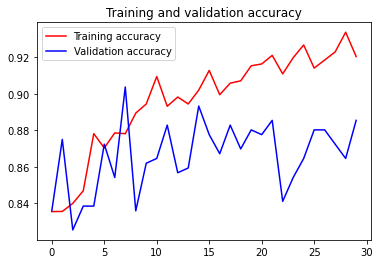

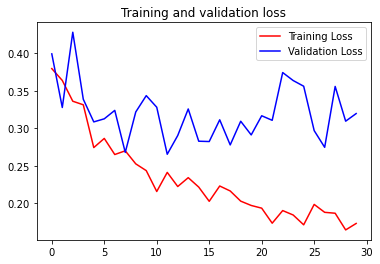

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [82]:
import h5py
model.save('mymodel.h5')
model.save('mymodel')